# 5º Período ✅

# Imports necessários para rede convolucional e análises correlacionadas

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import categorical_crossentropy  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import cv2 as cv
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)


In [25]:
# importando o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* O dataset de imagens 'animals' foi inserido no google drive.

## Carregando os dados (imagens) - 'cats', 'dogs' and 'panda'

* Organização da pasta inicial do drive para usar o método images_dataset_from_directory foi:

* animals
 * animals
    * cats
    * dogs 
    * panda

* O método usado para preparar os diretórios, separá-los em pastas de treino, validação e treino, dentro destas pastas, separar por classificação (cats, dogs and panda) e converter para o formato do *tensorflow* foi o **images_dataset_from_directory**. 

In [26]:
batch_size = 32
img_height = 180
img_width = 180

In [27]:
path = '/content/drive/MyDrive/IEEE/animals/animals'

* Separação de 20% para validação (valid and test) e 80% para o treino (train). 

* O método image_dataset_from_directory do Keras do TensorFlow faz isso.

In [28]:
train_df = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [29]:
val_df = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [30]:
names_types = train_df.class_names
print(names_types)

['cats', 'dogs', 'panda']


## Visualizando os dados 

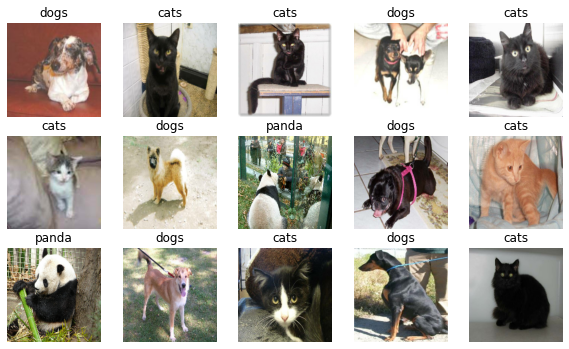

In [31]:
# visualizando 15 imagens do dataset de treino (train_df)

plt.figure(figsize = (10, 10))
for images, labels in train_df.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(names_types[labels[i]])
    plt.axis("off")

In [32]:
# normalizando os dados para o uso em rede neural convolucional 
# valores entre [0, 1] são comumente usados em rede neural e melhoram o desempenho da mesma
normalized_layer = tf.keras.layers.Rescaling(1./255)

In [33]:
normalized_df = train_df.map(lambda x, y: (normalized_layer(x), y))
image_path, labels_patch = next(iter(normalized_df))
first_image = image_path[0]

In [34]:
# os valores estão entre [0, 1]
print(np.min(first_image), np.max(first_image))

0.03686308 0.9967426


## Preparando o dataset para melhorar a performance 

* dataset.cache() e dataset.prefetch() são métodos que melhoram a performance da rede neural convolucional. Em linhas gerais, mantêm as imagens na memória por algum período e facilitam a compilação e o treinamento.

In [35]:
autotune = tf.data.AUTOTUNE

In [36]:
train_df = train_df.cache().prefetch(buffer_size = autotune)
val_df = val_df.cache().prefetch(buffer_size = autotune)

## Treinar o modelo com o Keras 

In [37]:
# criando uma rede neural convolucional
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(num_classes)
])

In [38]:
# compilação da rede neural convolucional
model.compile(
  optimizer = 'adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy'])

In [39]:
# treinamento da rede neural convolucional 
model.fit(train_df, validation_data = val_df, epochs = 3)

Epoch 1/3
75/75 [==============================] - 98s 1s/step - loss: 0.8571 - accuracy: 0.5646 - val_loss: 0.7429 - val_accuracy: 0.6217
Epoch 2/3
75/75 [==============================] - 88s 1s/step - loss: 0.6624 - accuracy: 0.6696 - val_loss: 0.6579 - val_accuracy: 0.6783
Epoch 3/3
75/75 [==============================] - 90s 1s/step - loss: 0.5564 - accuracy: 0.7287 - val_loss: 0.6624 - val_accuracy: 0.6767


* Não foi possível treinar a rede por mais época porque exigiu muito custo computacional, logo, demoraria muito tempo. 3 épocas demorou aproximadamente 7 minutos e 10 segundos. 

In [40]:
# acurácia da rede neural 
score = model.evaluate(val_df, verbose = 0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.6624119877815247
Test accuracy: 0.6766666769981384


## Transfer Learning VGG-16 

* Agora, será utilizado uma rede neural convolucional pré-treinada do VGG16 (Transfer Learning).

In [41]:
vgg = tf.keras.applications.VGG16(input_shape = (180, 180, 3), include_top = False, weights = 'imagenet')

In [42]:
# referenciando a forma da rede convolucional pré-treinada
x = vgg.output
x = Flatten()(x)
x = Dense(3078, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
out = Dense(5, activation = 'softmax')(x)

In [43]:
# congelando o treinamento de todas as camadas da rede 
tf_model = Model(inputs = vgg.input, outputs = out)

for layer in tf_model.layers[:20]:
  layer.trainable = False

In [44]:
# compilando a rede 
tf_model.compile(
  optimizer = 'adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy'])

In [45]:
# treinando a rede
# uma época, já que a qtde de dados é imensa
tf_train = tf_model.fit(train_df, batch_size = 1, epochs = 1, initial_epoch = 0, validation_data = val_df)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 967s 13s/step - loss: 17.2170 - accuracy: 0.8617 - val_loss: 3.7054 - val_accuracy: 0.9300


In [47]:
# acurácia da rede neural pré-treinada
score_tf = tf_model.evaluate(val_df, verbose = 0)
print(f'Test loss: {score_tf[0]}')
print(f'Test accuracy: {score_tf[1]}')

Test loss: 3.705425500869751
Test accuracy: 0.9300000071525574


In [49]:
# comparando score rede convolucional treinada
# com a rede convolucional pré-treinada

print(f'score_train = {score[0]} < score_pretrained = {score_tf[0]}')

score_train = 0.6624119877815247 < score_pretrained = 3.705425500869751


* Com uma rede pré-treinada, a qualidade das previsões das imagens em 'cats', 'dogs' e 'pandas' foi superior à rede convolucional criada e treinada anteriormente. Isso se deu em decorrência da grande quantidade de dados que precisam ser treinados e previstos. 

* Uma rede convolucional pré-treinada foi treinada com uma quantidade maior de dados e evita possíveis problemas de overfitting e evita grandes períodos de tempo para treinar bem e efetivamente uma rede convolucional do zero.

* Logo, em problemas de visão computacional, é muito comum usar redes convolucionais pré-treinadas para agilizar e tornar as previsões mais assertivas também.